In [1]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import torch
import torch.nn as nn

In [2]:
def func(data):
    x, t = data[:, 0], data[:, 1]
    return np.exp(-0.4*(np.pi**2)*t) * np.sin((np.pi)*x)

def PINN(NN, domain, num_train, learning_rate, num_itrs, num_test, itr_show=1000):
    model = NN
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    x = torch.linspace(0, 1, num_train)
    t = torch.linspace(0, 1, num_train)
    
    X, T = torch.meshgrid((x, t), indexing="ij")
    data = torch.vstack([X.ravel(), T.ravel()]).T 
    
    indices1 = (data[:, 0] == 0).nonzero(as_tuple=True)[0]
    indices2 = (data[:, 0] == 1).nonzero(as_tuple=True)[0]
    indices3 = (data[:, 1] == 0).nonzero(as_tuple=True)[0]

    all_indices = torch.cat([indices1, indices2])
    
    data.requires_grad = True

    for itr in range(num_itrs):
        f = model(data)
        
        dfdt = torch.autograd.grad(f, data, grad_outputs=torch.ones_like(f), create_graph=True)[0][:, 1]
        dfdx = torch.autograd.grad(f, data, grad_outputs=torch.ones_like(f), create_graph=True)[0][:, 0]
        dfdx2 = torch.autograd.grad(dfdx, data, grad_outputs=torch.ones_like(dfdx), create_graph=True)[0][:, 0]

        loss = torch.mean((dfdt - 0.4*dfdx2)**2) + torch.mean((f[all_indices])**2) + torch.mean((f[indices3] - torch.sin(torch.pi*data[indices3, 0:1]))**2)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if (itr+1) % itr_show == 0:
            print(f'iteration {itr+1}/{num_itrs}, loss = {loss}')

    x = torch.linspace(0, 1, num_test)
    t = torch.linspace(0, 1, num_test)
    
    X, T = torch.meshgrid((x, t), indexing="ij")
    data = torch.vstack([X.ravel(), T.ravel()]).T 
    
    predicted = model(data)
    predicted = torch.reshape(predicted, (num_test, num_test))
    
    plt.figure(figsize=(10, 6))
    cp = plt.contourf(X.cpu().detach().numpy(), T.cpu().detach().numpy(), predicted.cpu().detach().numpy())
    plt.colorbar(cp)
    plt.xlabel('t')
    plt.ylabel('x')
    plt.show()

In [3]:
torch.manual_seed(42)

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l5 = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        out = self.tanh(self.l1(x))
        out = self.tanh(self.l2(out))
        out = self.tanh(self.l3(out))
        out = self.l5(out)
        return out

        
input_size, hidden_size, output_size = 2, 50, 1
NN = NeuralNet(input_size, hidden_size, output_size)

iteration 1000/1000, loss = 7.782756438245997e-05


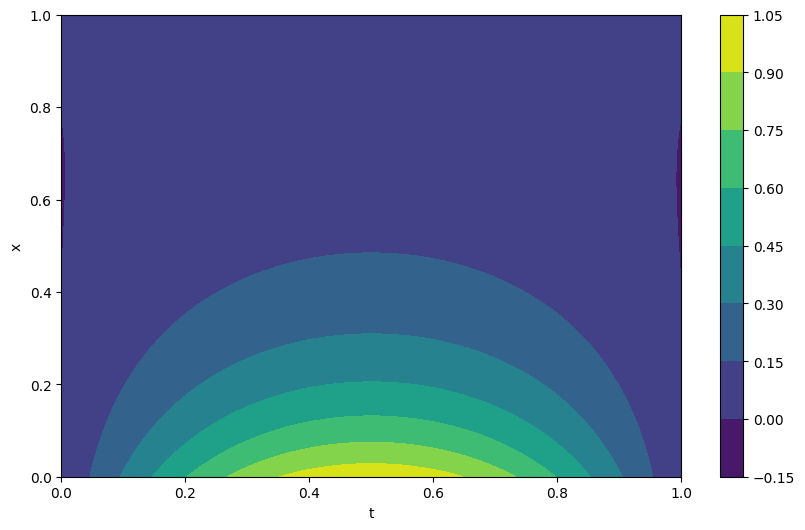

In [4]:
domain = (0, 1)
num_train = 30
num_test = 50
learning_rate = 0.001
num_itrs = 1000
PINN(NN, domain, num_train, learning_rate, num_itrs, num_test, itr_show=1000)